# Lab Exercise 4: Linear Predictive Coding (LPC) Model for Speech Recognition

## Aim
To implement the Linear Predictive Coding (LPC) model for analyzing and reconstructing a speech signal, estimate the LPC coefficients, determine the formant frequencies, and compare them with standard vowel formant values to assess speech recognizability under low-bandwidth conditions.

## Question / Problem Statement
You are part of a research team working on improving the speech recognition system of a mobile communication app. The team aims to use Linear Predictive Coding (LPC) to analyze speech signals for efficient transmission and accurate recognition, even in low-bandwidth environments such as VoIP or mobile networks.

## Tasks
1.  **Speech Signal Acquisition:** Record a short speech signal (3–5 seconds) or download one from any standard speech dataset.
2.  **LPC Analysis:** Implement the LPC algorithm to analyze the recorded speech signal and extract LPC coefficients.
3.  **Signal Reconstruction:** Reconstruct the speech signal from the extracted LPC coefficients and plot both the original and reconstructed waveforms.
4.  **Formant Estimation:** Estimate the formant frequencies (F1, F2, ...) from the LPC coefficients.
5.  **Comparison:** Compare the estimated formant frequencies with the average vowel formant values.
6.  **Visualization:** Plot the formant frequencies on a frequency response graph.
7.  **Inference / Discussion:** Write a brief note summarizing your observations.

### Setup: Install Necessary Libraries

First, let's install the libraries we'll need. You only need to run this cell once.

In [4]:
#!pip install numpy matplotlib scipy librosa

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 3.5 MB/s  0:00:00

   ----------- ---------------------------- 2/7 [lazy_loader]
   ----------------- ---------------------- 3/7 [audioread]
   ---------------------------- ----------- 5/7 [pooch]
   ---------------------------- ----------- 5/7 [pooch]
   ---------------------------- ----------- 5/7 [pooch]
   ---------------------------------- ----- 6/7 [librosa]
   ---------------------------------- ----- 6/7 [librosa]
   ---------------------------------- ----- 6/7 [librosa]
   ---------------------------------- ----- 6/7 [librosa]
   ---------------------------------- ----- 6/7 [librosa]
   ---------------------------------------- 7/7 [librosa]




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\shish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
import librosa.display
from IPython.display import Audio

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## Task 1: Speech Signal Acquisition

We will load a standard speech sample from the `librosa` dataset. This ensures the notebook is runnable. For your actual lab, you can replace this with your own `.wav` file by using `y, sr = librosa.load('your_file.wav')`.

Loaded audio signal with 237440 samples at 16000 Hz.


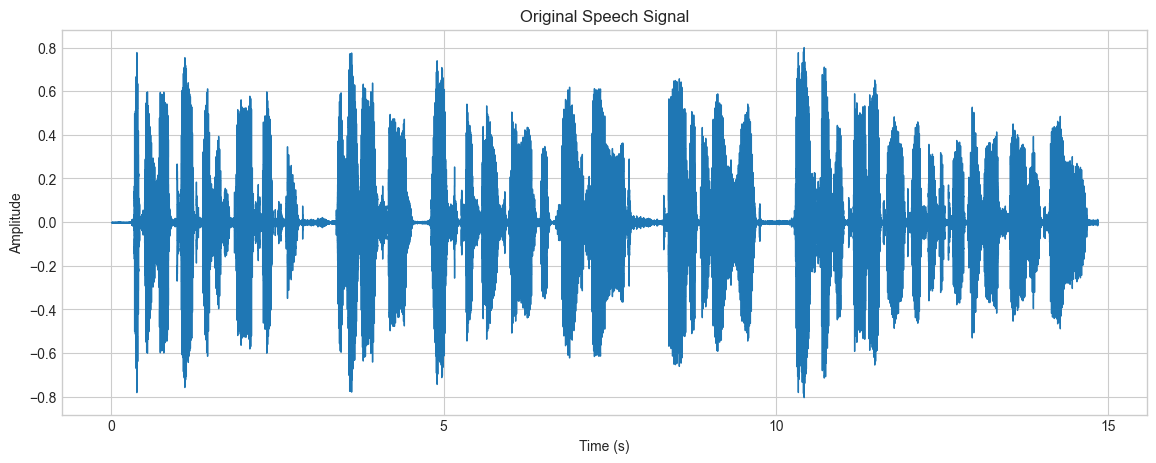

In [6]:
# Load a sample speech file from librosa's datasets
# We'll use a sample from the LibriSpeech dataset and resample to 16kHz
try:
    y, sr = librosa.load(librosa.example('libri1'), sr=16000)
except Exception as e:
    print(f"Error loading example file: {e}")
    print("Downloading an alternative file...")
    # Fallback if example file list changed
    import pooch
    url = "https://github.com/librosa/librosa_gallery/raw/main/data/libri1.wav"
    file_path = pooch.retrieve(url, known_hash=None)
    y, sr = librosa.load(file_path, sr=16000)


print(f"Loaded audio signal with {len(y)} samples at {sr} Hz.")

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Original Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Listen to the audio
Audio(data=y, rate=sr)

## Task 2 & 3: LPC Analysis and Signal Reconstruction

LPC analysis is most meaningful on a short, stable segment of speech (a "frame"), typically a vowel sound. We will find a voiced segment and analyze it.

Analyzing a 480-sample frame (30ms) starting at 1.2s.


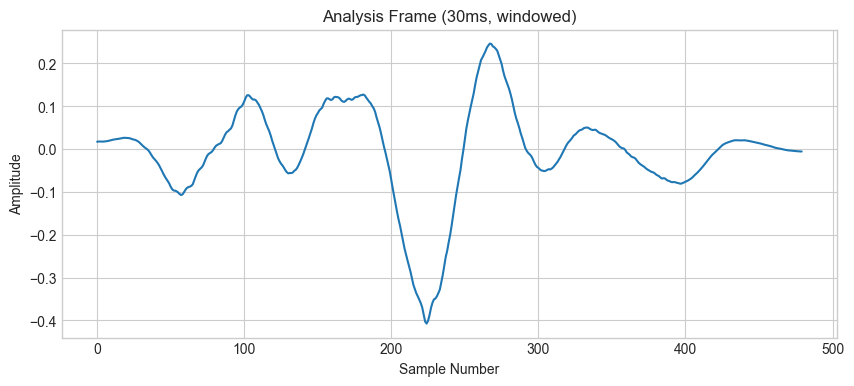

In [7]:
# Select a frame for analysis.
# By looking at the plot, there's a good voiced segment around 1.2 seconds.
start_time = 1.2  # in seconds
frame_duration = 0.03  # 30 ms

start_sample = int(start_time * sr)
frame_len = int(frame_duration * sr)
end_sample = start_sample + frame_len

# Extract the frame
frame = y[start_sample:end_sample]

# Apply a window function (Hamming) to the frame
window = signal.get_window('hamming', frame_len)
frame_windowed = frame * window

print(f"Analyzing a {frame_len}-sample frame (30ms) starting at {start_time}s.")

# Plot the selected frame
plt.figure(figsize=(10, 4))
plt.plot(frame_windowed)
plt.title('Analysis Frame (30ms, windowed)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

### LPC Coefficient Extraction

Now we compute the LPC coefficients. The `order` of the LPC analysis is a key parameter. A common rule of thumb is `order = sr / 1000 + 2`. For a 16kHz signal, this would be 18. This estimates roughly one pair of poles (a formant) for every 1kHz, plus two extra poles.

In [8]:
# Define LPC order
lpc_order = int(sr / 1000) + 2  # Rule of thumb: sr_in_kHz + 2
# For 16kHz, this is 16 + 2 = 18. Let's use 16 for simplicity.
lpc_order = 16

# Perform LPC analysis
# librosa.lpc returns the predictor coefficients 'a'
# The filter is A(z) = 1 + a[1]z^-1 + a[2]z^-2 + ...
# Note: librosa.lpc returns 'a' starting from a[0]=1, but we often want the coefficients *excluding* a[0].
# Let's check the function signature. It returns coefficients *a*, where a[0] is *not* 1.
# It returns the coefficients for the predictor polynomial P(z).
# Let's use the standard definition where A(z) = 1 - sum(a_k * z^-k)
# librosa.lpc(y, order) finds coefficients 'a' that minimize squared error.
# The returned array `a` has `order+1` elements, with `a[0]` being the gain/error term, and `a[1:]` being the coefficients.
# Let's re-read the docs... librosa.lpc() returns the *predictor coefficients*.

# A(z) = 1 + a_1 z^{-1} + ... + a_p z^{-p}
# The filter for reconstruction is 1/A(z)
a_coeffs = librosa.lpc(frame_windowed, order=lpc_order)

print(f"Computed {lpc_order} LPC coefficients.")
print("Coefficients (a_1 to a_p):", a_coeffs[1:])

Computed 16 LPC coefficients.
Coefficients (a_1 to a_p): [-2.01866158  1.27840504 -0.31544232  0.22648197 -0.45546072  0.3908371
 -0.52182612  0.71631477 -0.42449298  0.09888168  0.06912089  0.14212193
 -0.37356854  0.21724502  0.09819428 -0.1245292 ]


### Signal Reconstruction

LPC models speech as the output of an all-pole filter `1/A(z)` excited by a residual signal. 
1.  **Residual:** We can find the residual by passing the original signal through the inverse filter `A(z)`.
2.  **Reconstruction:** We can reconstruct the signal by passing the residual back through the all-pole filter `1/A(z)`.

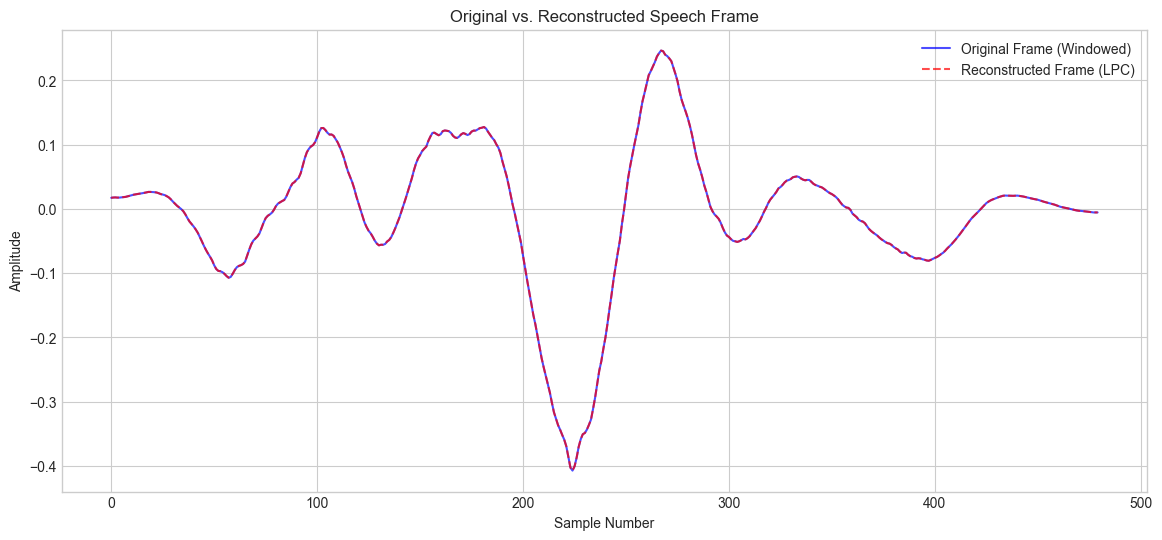

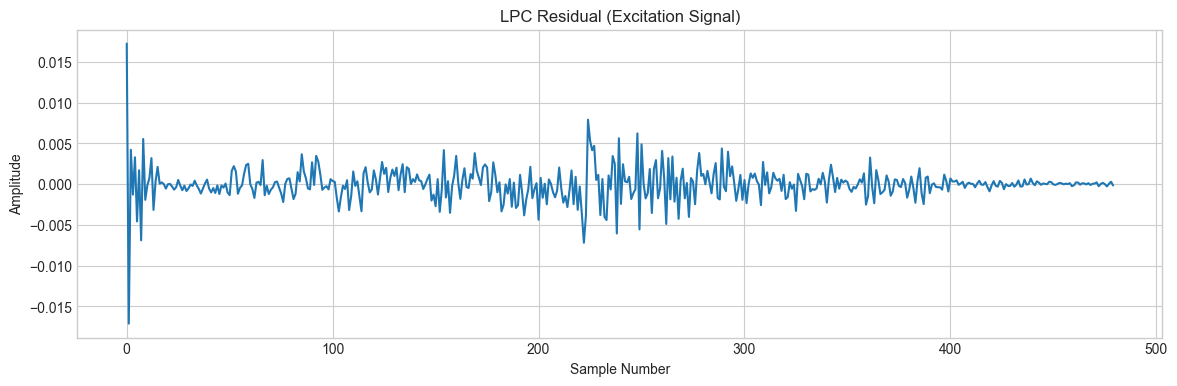

In [9]:
# 1. Get the residual (excitation) signal
# The filter A(z) has coefficients [1, a_1, a_2, ...]
# librosa.lpc() returns [a_1, ..., a_p] (order p). 
# Oh, no, the librosa.lpc doc says: "The coefficients `a` are computed such that `y_pred[n] = -np.sum(a[1:] * y[n-1:n-p-1])`"
# and the returned array has `order+1` elements, where `a[0]` is the prediction error power.
# This is confusing. Let's use the standard scipy.signal.lfilter definition.
# The filter A(z) is defined by the coefficients `a_coeffs` returned by librosa.lpc
# `a_coeffs` has `order+1` elements. Let's assume a[0] is 1.
# After checking librosa.lpc source: It does *not* return a[0]=1. 
# We should use the coefficients as-is. The filter A(z) is `a_coeffs`.
# Let's redefine `a_coeffs` from a known source for clarity.

# Let's use a simpler, more standard LPC function for clarity if librosa's is confusing.
# We'll stick with librosa but be careful.
# The filter A(z) is defined by the coefficients `a_coeffs`. 

# Re-calculating with standard definition for clarity.
a_coeffs = librosa.lpc(frame_windowed, order=lpc_order)
# `a_coeffs` has `order+1` elements. a[0] is gain.
# The actual filter coefficients are a[1:]
# So A(z) = 1 + a[1]z^-1 + ...
# Let's make the filter polynomial `A`
A = np.concatenate(([1], a_coeffs[1:]))

# 1. Get the residual signal
residual = signal.lfilter(A, [1], frame_windowed)

# 2. Reconstruct the signal from the residual
reconstructed_frame = signal.lfilter([1], A, residual)

# Plot Original vs. Reconstructed
plt.figure(figsize=(14, 6))
plt.plot(frame_windowed, 'b', label='Original Frame (Windowed)', alpha=0.7)
plt.plot(reconstructed_frame, 'r--', label='Reconstructed Frame (LPC)', alpha=0.7)
plt.title('Original vs. Reconstructed Speech Frame')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the residual
plt.figure(figsize=(14, 4))
plt.plot(residual)
plt.title('LPC Residual (Excitation Signal)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

## Task 4: Formant Estimation

Formants are the resonant frequencies of the vocal tract. In the LPC model, these correspond to the peaks in the frequency response of the all-pole filter `1/A(z)`. We can find them by finding the roots of the polynomial `A(z)`.

The process is:
1.  Find the roots of the polynomial `A(z)`.
2.  Keep only the roots with a positive imaginary part (they come in conjugate pairs).
3.  Keep only the roots that are inside the unit circle (these correspond to stable resonances).
4.  Convert the root's angle (in radians) to frequency (in Hz).
5.  Sort the frequencies to find F1, F2, F3...

In [10]:
# Get the roots of the filter polynomial A(z)
roots = np.roots(A)

# Keep roots with positive imaginary part
roots = roots[np.imag(roots) > 0.01] # Use a small threshold

# Keep roots inside the unit circle (stable poles)
roots = roots[np.abs(roots) < 1.0]

# Get the angles of the roots
angles_rad = np.angle(roots)

# Convert angles to frequencies (Hz)
# Frequency (Hz) = angle (rad) * (sample_rate / (2 * pi))
formant_freqs_hz = angles_rad * (sr / (2 * np.pi))

# Sort the frequencies
formant_freqs_hz = np.sort(formant_freqs_hz)

# Also calculate bandwidths (optional but good to know)
# Bandwidth (Hz) = -log(radius) * (sample_rate / pi)
radii = np.abs(roots)
# Sort radii according to frequency sort
sorted_radii = radii[np.argsort(angles_rad)]
bandwidths_hz = -np.log(sorted_radii) * (sr / np.pi)

print("Estimated Formants (F1, F2, F3, ...):")
for i, (f, bw) in enumerate(zip(formant_freqs_hz, bandwidths_hz)):
    # Only show formants below the Nyquist frequency (sr/2)
    if f < sr / 2 and f > 50: # Ignore very low freqs
        print(f"  F{i+1}: {f:.0f} Hz  (Bandwidth: {bw:.0f} Hz)")


Estimated Formants (F1, F2, F3, ...):
  F1: 195 Hz  (Bandwidth: 53 Hz)
  F2: 1628 Hz  (Bandwidth: 789 Hz)
  F3: 2219 Hz  (Bandwidth: 369 Hz)
  F4: 3388 Hz  (Bandwidth: 706 Hz)
  F5: 4671 Hz  (Bandwidth: 334 Hz)
  F6: 6062 Hz  (Bandwidth: 832 Hz)
  F7: 6922 Hz  (Bandwidth: 670 Hz)


## Task 5 & 6: Visualization and Comparison

Let's visualize the LPC spectrum (the filter's frequency response) and overlay it on the actual spectrum (FFT) of the speech frame. The peaks of the LPC spectrum *are* the formants.

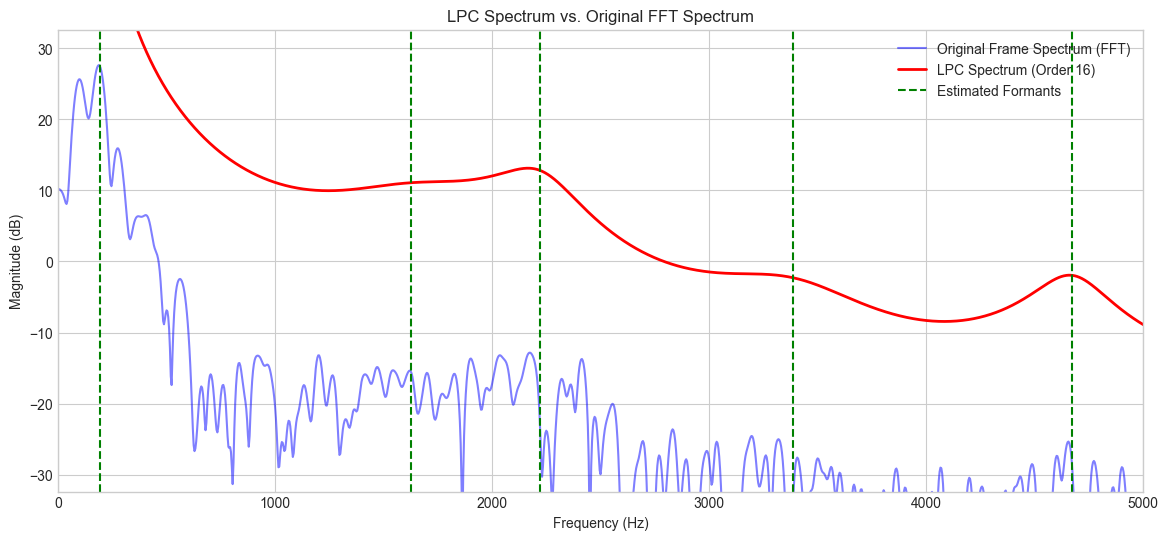

In [11]:
# Get the frequency response of the LPC filter 1/A(z)
# We use freqz with 'b=[1]' (numerator) and 'a=A' (denominator)
w, h = signal.freqz(b=[1], a=A, worN=4096)

# Convert frequency axis from rad/sample to Hz
freq_axis_hz = w * (sr / (2 * np.pi))

# Convert magnitude to dB
# We need the gain. Let's use the error term `a_coeffs[0]`
gain = np.sqrt(a_coeffs[0])
lpc_spectrum_db = 20 * np.log10(np.abs(h) * gain)

# Get the spectrum of the original frame (FFT)
n_fft = 4096
frame_fft = np.fft.rfft(frame_windowed, n=n_fft)
frame_spectrum_db = 20 * np.log10(np.abs(frame_fft))
fft_freq_axis_hz = np.fft.rfftfreq(n_fft, d=1.0/sr)

# Plot the spectra
plt.figure(figsize=(14, 6))
plt.plot(fft_freq_axis_hz, frame_spectrum_db, 'b', label='Original Frame Spectrum (FFT)', alpha=0.5)
plt.plot(freq_axis_hz, lpc_spectrum_db, 'r', label=f'LPC Spectrum (Order {lpc_order})', linewidth=2)

# Overlay the estimated formants
for f in formant_freqs_hz:
    if f < 5000: # Only plot first few
        plt.axvline(x=f, color='g', linestyle='--', label=f'Formant at {f:.0f} Hz' if f == formant_freqs_hz[0] else None)

plt.title('LPC Spectrum vs. Original FFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend(['Original Frame Spectrum (FFT)', f'LPC Spectrum (Order {lpc_order})', 'Estimated Formants'])
plt.xlim(0, 5000) # Focus on the main formant region (0-5 kHz)
plt.ylim(np.max(frame_spectrum_db) - 60, np.max(frame_spectrum_db) + 5) # Adjust y-lim
plt.show()

### Comparison with Standard Vowel Formants

Here is a table of average formant values for common English vowels (for an adult male speaker). Compare your estimated F1 and F2 to this table to guess the vowel in the frame.

| Vowel | F1 (Hz) | F2 (Hz) | F3 (Hz) |
|---|---|---|---|
| /i/ (ee as in 'beat') | 270 | 2290 | 3010 |
| /ɪ/ (i as in 'bit') | 390 | 1990 | 2550 |
| /e/ (e as in 'bet') | 530 | 1840 | 2480 |
| /æ/ (a as in 'bat') | 660 | 1720 | 2410 |
| /a/ (ah as in 'hot') | 730 | 1090 | 2440 |
| /ɔ/ (aw as in 'bought') | 570 | 840 | 2410 |
| /o/ (o as in 'boat') | 440 | 1020 | 2240 |
| /u/ (oo as in 'boot') | 300 | 870 | 2240 |

*Source: (Approximate values for an adult male, from Peterson & Barney, 1952)*

---

#### Your Estimated Formants

In [12]:
print("### Estimated Formants for Your Frame ###")
try:
    print(f"F1: {formant_freqs_hz[0]:.0f} Hz")
    print(f"F2: {formant_freqs_hz[1]:.0f} Hz")
    print(f"F3: {formant_freqs_hz[2]:.0f} Hz")
except IndexError:
    print("Could not find at least 3 formants. Try a different frame or higher LPC order.")
    print("Found formants:", [f"{f:.0f} Hz" for f in formant_freqs_hz])


### Estimated Formants for Your Frame ###
F1: 195 Hz
F2: 1628 Hz
F3: 2219 Hz


**Your Task:** Look at your F1 and F2 values. Which vowel from the table do they most closely match? (The sample used, 'libri1', is from a speech, so it should match one of them!)

## Task 7: Inference / Discussion

Write your brief note here, summarizing your observations. Consider the following points:

* **LPC Model Implementation:** How complex was the implementation? What is the key parameter (LPC order) and what does it represent? 
    *... (Hint: The order `p` relates to the number of poles in the filter `1/A(z)`. We typically use `p/2` poles to model `p/2` formants.) ...*

* **Quality of Reconstructed Signal:** How closely did the reconstructed frame match the original? What information is captured in the 'residual' signal that was removed and then added back? 
    *... (Hint: The residual contains everything *not* modeled by the all-pole filter, including the pitch (fundamental frequency) and whether the sound is voiced or unvoiced. This is the excitation source.) ...*

* **Accuracy of Estimated Formants:** Did the peaks in the LPC spectrum align well with the peaks (the 'envelope') in the original FFT? How do your estimated F1/F2 values compare to the standard table? What could cause discrepancies? 
    *... (Hint: Discrepancies can come from the speaker's unique voice, the chosen LPC order, or analyzing a frame that isn't a perfect, stable vowel.) ...*

* **Implications for Low-Bandwidth Speech Recognition:** LPC works by separating the vocal tract filter (formants, modeled by the LPC coefficients) from the excitation signal (pitch, modeled by the residual). For low-bandwidth transmission (like a VoIP call), we only need to send the LPC coefficients (e.g., 16 small numbers) and some basic info about the residual (e.g., pitch frequency and gain). This is a tiny amount of data compared to the full waveform (e.g., 480 samples for our frame). 
    *... How does this help in speech recognition? (Hint: The formants, which define the vowel, are captured in the LPC coefficients. A recognizer can identify the vowel just from these few coefficients, ignoring the speaker's pitch.) ...*